In [ ]:
##Date:29/05/2021


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers, optimizers

print(tf.__version__)

2.5.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/'My Drive'/CML/

Image_classification_data.zip


In [4]:
!cp /content/drive/'My Drive'/CML/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [5]:
# reading the MainData CSV file
data1 = pd.read_csv('./data_labels_mainData.csv',delimiter=',')
data1.head(5)


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [6]:
# Dropping CellType and CellType name as that is not required for predicting isCancerous

data1.drop('cellType', inplace=True, axis=1)
data1.drop('cellTypeName', inplace=True, axis=1)

In [7]:
data1.head(5)


,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


In [8]:
index = data1.index
number_of_rows = len(index)
print(number_of_rows)

9896


In [9]:
# Loading ExtrasData 

data_extra = pd.read_csv('./data_labels_extraData.csv',delimiter=',')
data_extra.head(5)

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [10]:
# Concatinating mainData and Extras data
frames = [data1, data_extra]
data = pd.concat(frames)

In [11]:
data.head(5)

,InstanceID,patientID,ImageName,isCancerous
0,22405,1,22405.png,0
1,22406,1,22406.png,0
2,22407,1,22407.png,0
3,22408,1,22408.png,0
4,22409,1,22409.png,0


In [12]:
index_f = data.index
number_of_rows_f = len(index_f)
print(number_of_rows_f)

20280


(array([13211.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7069.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

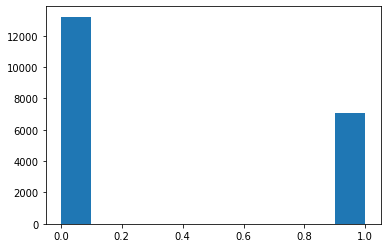

In [13]:
# Checking distribution of class distribution

y=data['isCancerous']
plt.hist(y)

In [14]:
# Adding image path in the dataframe

data['ImagePath'] = 'patch_images/' + data['ImageName'].astype(str)
data.head(5)

,InstanceID,patientID,ImageName,isCancerous,ImagePath
0,22405,1,22405.png,0,patch_images/22405.png
1,22406,1,22406.png,0,patch_images/22406.png
2,22407,1,22407.png,0,patch_images/22407.png
3,22408,1,22408.png,0,patch_images/22408.png
4,22409,1,22409.png,0,patch_images/22409.png


In [15]:
#To check if there is any unexpected data in the merged data frame
data['ImagePath'].isnull().values.any()

False

In [16]:
#Train-Validation-Test Split(60-20-20)
#Stratifying based on PAtient iD

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify = data.patientID)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify = train_data.patientID)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [17]:
train_data.head()

,InstanceID,patientID,ImageName,isCancerous,ImagePath
492,11555,65,11555.png,1,patch_images/11555.png
7585,7448,88,7448.png,1,patch_images/7448.png
3853,5431,78,5431.png,1,patch_images/5431.png
5814,19871,33,19871.png,0,patch_images/19871.png
70,18832,3,18832.png,0,patch_images/18832.png


(array([7926.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4242.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

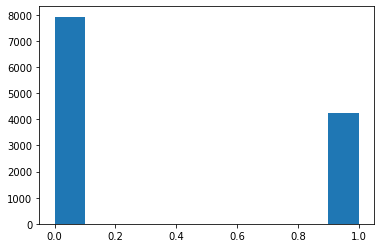

In [18]:
target=train_data['isCancerous']
plt.hist(target)

In [19]:
# Plotting images of cancerous cells and non-cancerous cells

cancerCell_df = train_data.groupby('isCancerous').first()

cancerCell_df['index'] = range(1, len(cancerCell_df) + 1)


In [20]:
cancerCell_df = cancerCell_df.reset_index()


In [21]:
cancerCell_df

,isCancerous,InstanceID,patientID,ImageName,ImagePath,index
0,0,19871,33,19871.png,patch_images/19871.png,1
1,1,11555,65,11555.png,patch_images/11555.png,2


In [22]:

cancerCell_df['isCancerous'] = cancerCell_df['isCancerous'].astype('str')

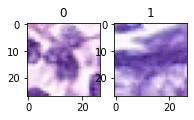

In [23]:
img_list=list(cancerCell_df.ImagePath)
target_list=list(target)

for i,rows in cancerCell_df.iterrows():
  plt.subplot(1,4,rows['index'])
  img = Image.open(rows['ImagePath'])

  plt.imshow(img)
  plt.title(rows['isCancerous'])


In [24]:
# Checking dimension of the input images

img=Image.open(img_list[1])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH: W:{} C:{}'.format(img_numpy.shape[0],img_numpy.shape[1],img_numpy.shape[2]))

Image size 
H: W:27 C:27


In [25]:
## Defining function for plotting learning curve

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [26]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [ ]:
## Multi Layer Perceptron

In [28]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [29]:

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 64

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [30]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImagePath",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
## Building MLP model

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


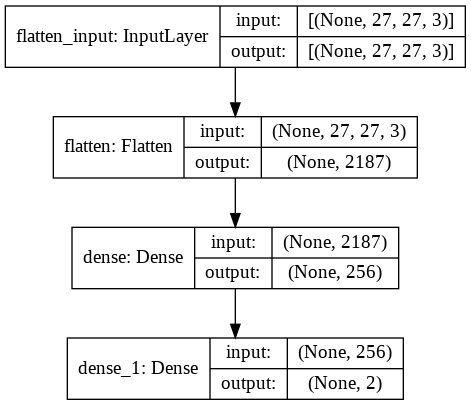

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
sgd = optimizers.SGD(lr=0.01)

model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


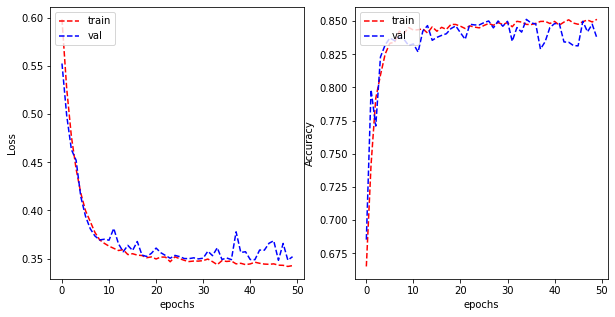

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model.evaluate(train_generator)

191/191 [==============================] - 3s 15ms/step - loss: 0.3429 - categorical_accuracy: 0.8501


[0.34289100766181946, 0.8500986099243164]

In [ ]:
model.evaluate(validation_generator)

64/64 [==============================] - 1s 15ms/step - loss: 0.3545 - categorical_accuracy: 0.8476


[0.35454022884368896, 0.8476331233978271]

In [ ]:
model.evaluate(test_generator)

4056/4056 [==============================] - 9s 2ms/step - loss: 0.3540 - categorical_accuracy: 0.8454


[0.3539871871471405, 0.8454142212867737]

In [ ]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
print("ROC-AUC Score: ", roc_auc_score(y_all,y_hat_all, average="macro"))

print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8454142011834319
F1 score:  0.8329722658819927
Precision Score:  0.8287728103892227
Recall Score:  0.8383832443137491
ROC-AUC Score:  0.838383244313749
[[2268  363]
 [ 264 1161]]


In [ ]:
def build_model_MLP( learning_rate, Hidden_layer):
    OUTPUT_CLASSES=2

    model_MLP = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(Hidden_layer, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
    
    model_MLP.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    

    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)
    model_history = model_MLP.fit_generator(train_generator, validation_data = validation_generator, callbacks=[monitor], epochs=100, verbose=0)

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model_MLP.evaluate(test_generator)))
        
    return model_MLP

learning_rate= 0.001 , Neurons in Hidden layer= 128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


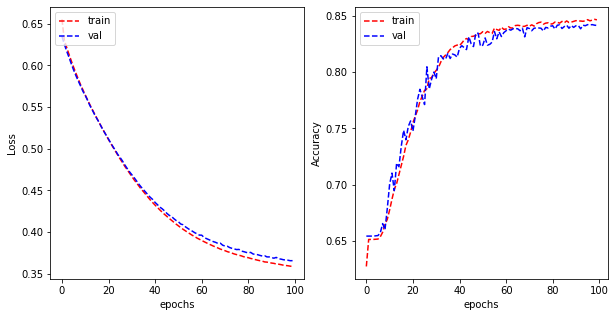

4056/4056 [==============================] - 9s 2ms/step - loss: 0.3626 - categorical_accuracy: 0.8452
Performance on test data:  [0.36261627078056335, 0.8451676368713379]
* End of iteration *

learning_rate= 0.001 , Neurons in Hidden layer= 256


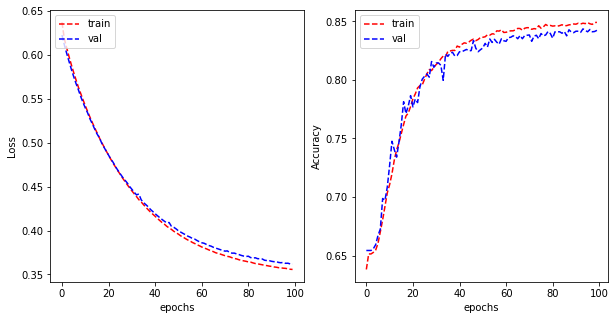

4056/4056 [==============================] - 9s 2ms/step - loss: 0.3595 - categorical_accuracy: 0.8508
Performance on test data:  [0.35954993963241577, 0.8508382439613342]
* End of iteration *

learning_rate= 0.01 , Neurons in Hidden layer= 128


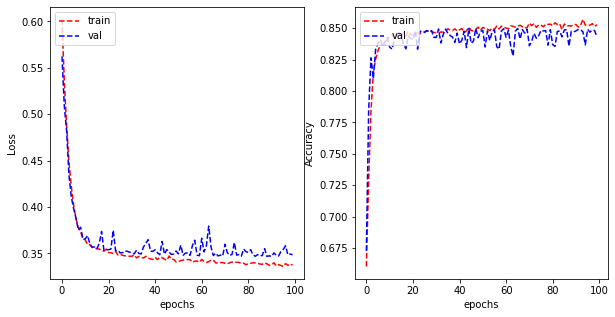

4056/4056 [==============================] - 9s 2ms/step - loss: 0.3483 - categorical_accuracy: 0.8464
Performance on test data:  [0.34831541776657104, 0.8464003801345825]
* End of iteration *

learning_rate= 0.01 , Neurons in Hidden layer= 256


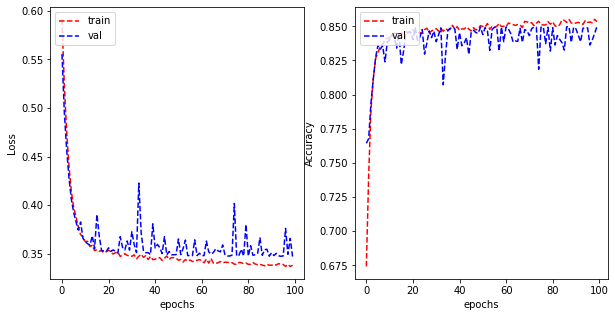

4056/4056 [==============================] - 9s 2ms/step - loss: 0.3466 - categorical_accuracy: 0.8499
Performance on test data:  [0.34662875533103943, 0.8498520851135254]
* End of iteration *



In [ ]:
learning_rate = [0.001, 0.01]
Hidden_layer = [128, 256]

for lr in learning_rate:
    for hl in Hidden_layer:
        print("learning_rate=",lr,", Neurons in Hidden layer=",hl)
                
        build_model_MLP(lr, hl)
        
        print("* End of iteration *")
            
        print()

In [ ]:
# Lr=0.01, Hidden Layer-128 , i.e the MLP model with this parameter is performing better in terms of accuracy and overfitting. Lets try treating the overfitting by adding regularizer

In [31]:
## Building MLP-best model
reg_lambda = 0.01

model_MLP_Best = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(128,kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

In [32]:
sgd = optimizers.SGD(lr=0.001)

model_MLP_Best.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


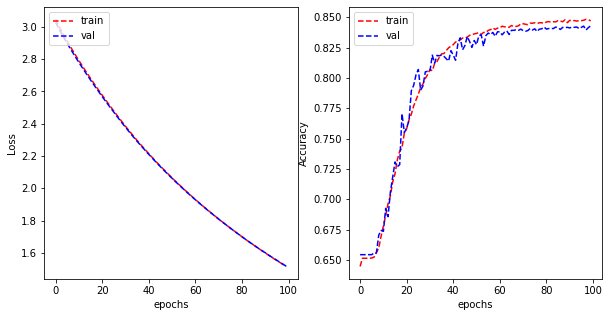

In [33]:
history = model_MLP_Best.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [34]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_MLP_Best.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
print("ROC-AUC Score: ", roc_auc_score(y_all,y_hat_all, average="macro"))

print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8473865877712031
F1 score:  0.8281507331402789
Precision Score:  0.8389684414384013
Recall Score:  0.8204424973494169
ROC-AUC Score:  0.8204424973494169
[[2397  234]
 [ 385 1040]]


In [ ]:
## Modified Lenet Architecture

In [ ]:
model_lenet1 = tf.keras.Sequential([
                              
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(27, 27, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [ ]:
sgd = optimizers.SGD()
model_lenet1.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


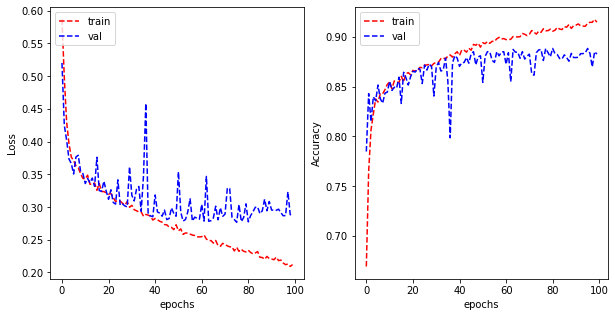

In [ ]:
history_lenet1 = model_lenet1.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_lenet1.history['loss'], history_lenet1.history['val_loss'], 
                    history_lenet1.history['categorical_accuracy'], history_lenet1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# Hyperparameter tuning by changing reg_lambda, learning_rate, dense_layer

In [ ]:
def build_model_lenet(reg_lambda, learning_rate, dense_layer):
    model_lenet = tf.keras.Sequential([
                              
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),input_shape=(27, 27, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Conv2D(32 , kernel_size=(5, 5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_layer, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])
    
    model_lenet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-5,patience=80,verbose=1,restore_best_weights=True)
    model_history = model_lenet.fit_generator(train_generator, validation_data = validation_generator, callbacks=[monitor], epochs=100, verbose=0)

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model_lenet.evaluate(test_generator)))
        
    return model_lenet
 

Training for reg_lamda = 0.001 , learning_rate= 0.001 , Neurons in dense layer= 128


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


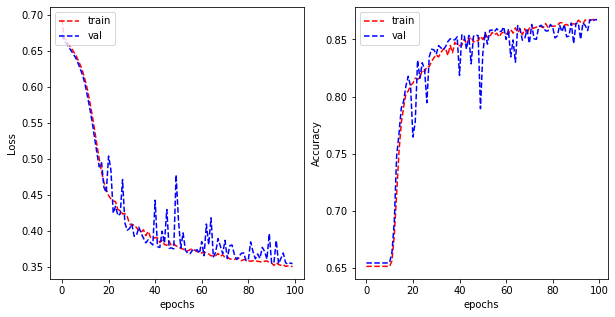

4056/4056 [==============================] - 11s 3ms/step - loss: 0.3531 - categorical_accuracy: 0.8592
Performance on test data:  [0.353070467710495, 0.8592209219932556]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.001 , Neurons in dense layer= 256


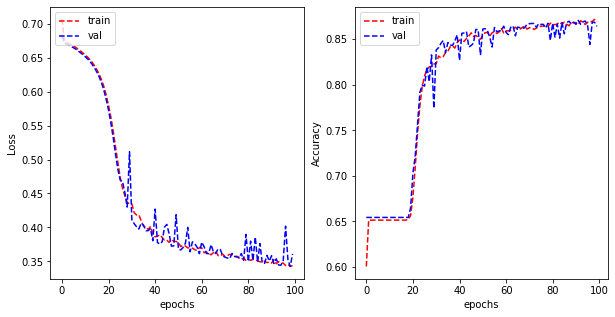

4056/4056 [==============================] - 11s 3ms/step - loss: 0.3613 - categorical_accuracy: 0.8609
Performance on test data:  [0.361326664686203, 0.860946774482727]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.01 , Neurons in dense layer= 128


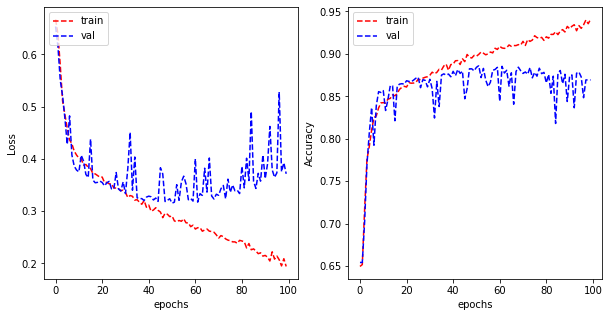

4056/4056 [==============================] - 11s 3ms/step - loss: 0.3833 - categorical_accuracy: 0.8622
Performance on test data:  [0.3833419978618622, 0.8621794581413269]
* End of iteration *

Training for reg_lamda = 0.001 , learning_rate= 0.01 , Neurons in dense layer= 256


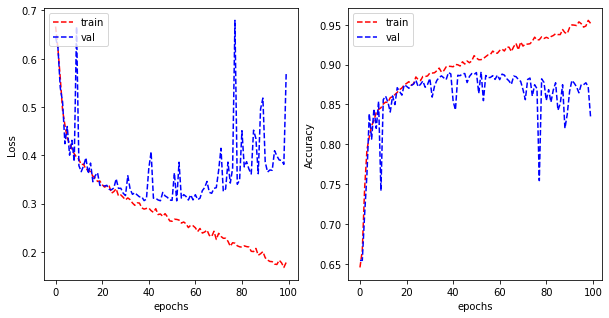

4056/4056 [==============================] - 12s 3ms/step - loss: 0.5742 - categorical_accuracy: 0.8388
Performance on test data:  [0.5741975903511047, 0.8387573957443237]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.001 , Neurons in dense layer= 128


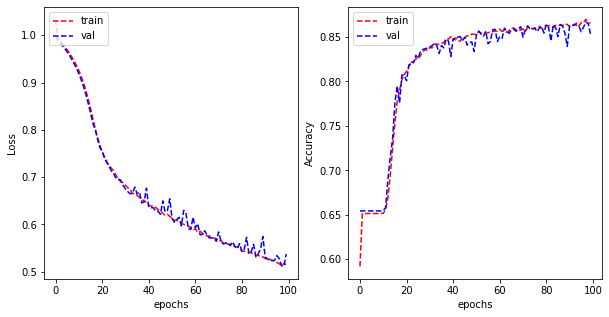

4056/4056 [==============================] - 11s 3ms/step - loss: 0.5356 - categorical_accuracy: 0.8560
Performance on test data:  [0.5355619788169861, 0.8560158014297485]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.001 , Neurons in dense layer= 256


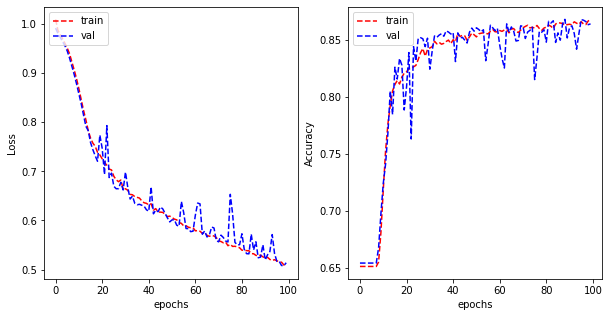

4056/4056 [==============================] - 12s 3ms/step - loss: 0.5143 - categorical_accuracy: 0.8585
Performance on test data:  [0.5142691731452942, 0.8584812879562378]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.01 , Neurons in dense layer= 128


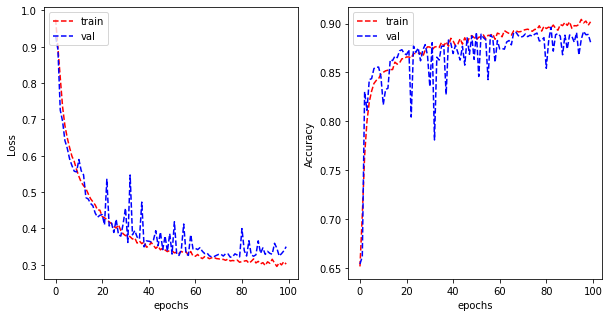

4056/4056 [==============================] - 11s 3ms/step - loss: 0.3553 - categorical_accuracy: 0.8792
Performance on test data:  [0.35528117418289185, 0.8791913390159607]
* End of iteration *

Training for reg_lamda = 0.01 , learning_rate= 0.01 , Neurons in dense layer= 256


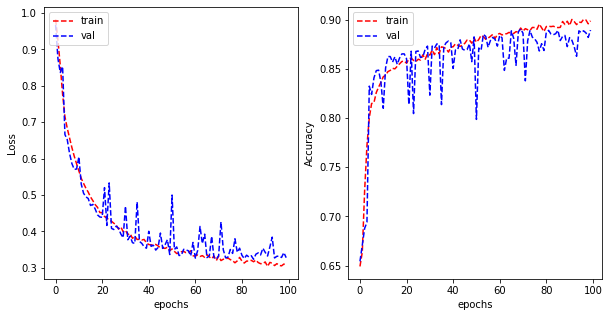

4056/4056 [==============================] - 12s 3ms/step - loss: 0.3374 - categorical_accuracy: 0.8814
Performance on test data:  [0.33737191557884216, 0.8814102411270142]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.001 , Neurons in dense layer= 128


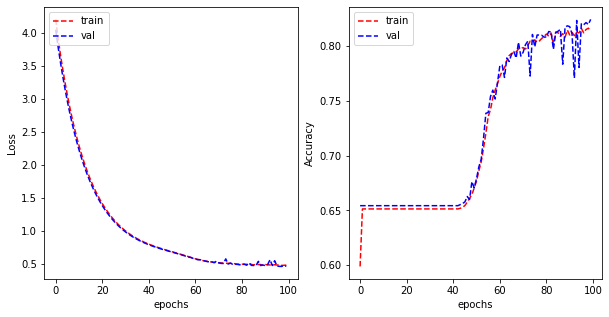

4056/4056 [==============================] - 12s 3ms/step - loss: 0.4633 - categorical_accuracy: 0.8195
Performance on test data:  [0.46331554651260376, 0.8195266127586365]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.001 , Neurons in dense layer= 256


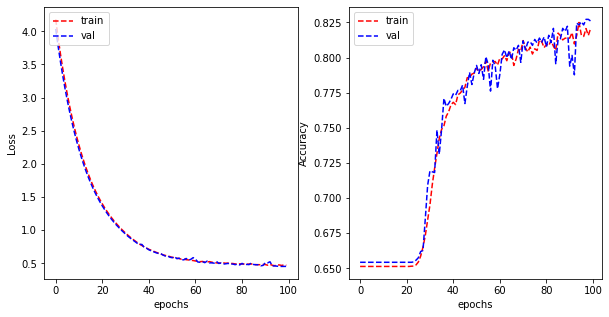

4056/4056 [==============================] - 12s 3ms/step - loss: 0.4570 - categorical_accuracy: 0.8220
Performance on test data:  [0.4570091962814331, 0.8219920992851257]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.01 , Neurons in dense layer= 128


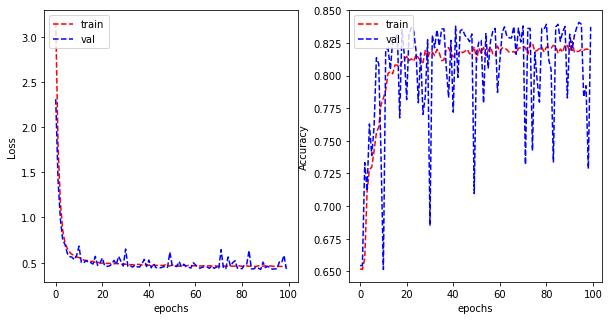

4056/4056 [==============================] - 12s 3ms/step - loss: 0.4286 - categorical_accuracy: 0.8356
Performance on test data:  [0.4286257326602936, 0.8355522751808167]
* End of iteration *

Training for reg_lamda = 0.1 , learning_rate= 0.01 , Neurons in dense layer= 256
Restoring model weights from the end of the best epoch.
Epoch 00088: early stopping


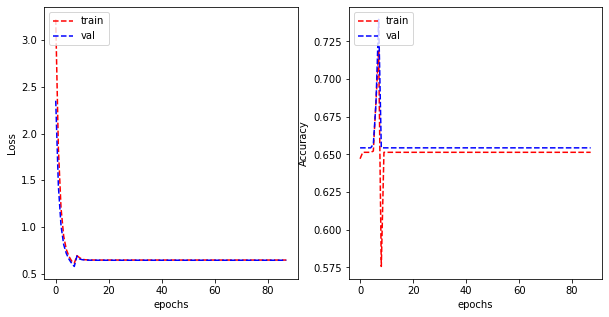

4056/4056 [==============================] - 12s 3ms/step - loss: 0.5790 - categorical_accuracy: 0.7318
Performance on test data:  [0.578951358795166, 0.7317554354667664]
* End of iteration *



In [ ]:
reg_lambda = [0.001, 0.01, 0.1]
learning_rate = [0.001, 0.01]
dense_layer = [128, 256]

for reg in reg_lambda:
    for lr in learning_rate:
        for dl in dense_layer:
            print("Training for reg_lamda =",reg,", learning_rate=",lr,", Neurons in dense layer=",dl)
                
            build_model_lenet(reg, lr, dl)
        
            print("* End of iteration *")
            
            print()

In [ ]:
# Best Lenet Model after hyperparameter tuning

In [35]:
reg_lambda=0.01
model_lenet_Best = tf.keras.Sequential([
                              
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),input_shape=(27, 27, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Conv2D(32 , kernel_size=(5, 5), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [36]:
sgd = optimizers.SGD(learning_rate=0.001)
model_lenet_Best.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


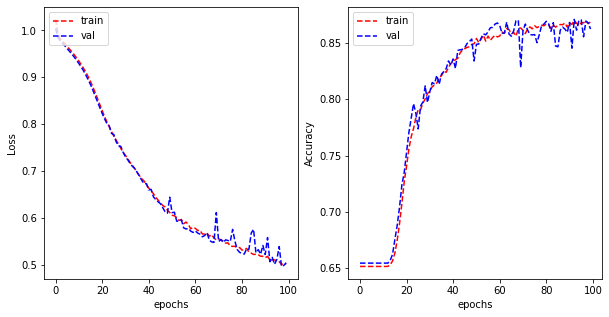

In [37]:
history_lenet_Best = model_lenet_Best.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_lenet_Best.history['loss'], history_lenet_Best.history['val_loss'], 
                    history_lenet_Best.history['categorical_accuracy'], history_lenet_Best.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [39]:
model_lenet_Best.evaluate(train_generator)

191/191 [==============================] - 3s 14ms/step - loss: 0.5000 - categorical_accuracy: 0.8711


[0.49997785687446594, 0.8710552453994751]

In [40]:
model_lenet_Best.evaluate(validation_generator)

64/64 [==============================] - 1s 14ms/step - loss: 0.5044 - categorical_accuracy: 0.8624


[0.5043759346008301, 0.8624260425567627]

In [41]:
model_lenet_Best.evaluate(test_generator)

4056/4056 [==============================] - 11s 3ms/step - loss: 0.5078 - categorical_accuracy: 0.8656


[0.5077669620513916, 0.8656311631202698]

In [42]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_lenet_Best.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
print("ROC-AUC Score: ", roc_auc_score(y_all,y_hat_all, average="macro"))

print(confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8656311637080868
F1 score:  0.845973270455042
Precision Score:  0.867579630434245
Recall Score:  0.8330580727760107
ROC-AUC Score:  0.8330580727760107
[[2480  151]
 [ 394 1031]]


In [ ]:
# We did not choose to aadress the class imbalance problem in predicting the the cancerous cell because of the fact that all the models in Lenet, VGG or MLP were performing good in all performance metric. May be bacause of the fact that we used 20000 observations to train the model.